# Traffic Forecasting Analysis

Traffic predictions using different models.

Import required package and connect to Google Drive

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


Get dataset files

In [93]:
#METR-LA dataset
#!cp /content/drive/MyDrive/metr-la.csv /content/dataset.csv

#Pems-bay dataset
#!cp /content/drive/MyDrive/pems-bay.csv /content/dataset.csv

#Pemsd7-m dataset
!cp /content/drive/MyDrive/pemsd7-m.csv /content/dataset.csv

Create DataFrame and visualize its structure

In [94]:
#dataset path
path = '/content/dataset.csv'

#add columns header
df = pd.read_csv(path, header=None)

In [95]:
#remove entries with null values
df = df.dropna(axis=0)

shape = df.shape
size = df.size

print(f'Dataframe shape: {shape}')
print(f'Number of elements: {size}')
df.head()

Dataframe shape: (12672, 228)
Number of elements: 2889216


,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1


In [96]:
#convert to numpy array
dataset = df.values

Visualize values from a sensor in the first day

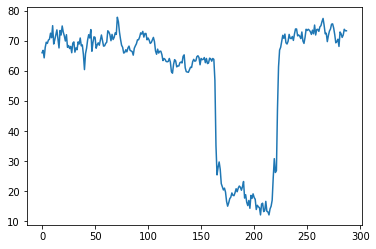

In [97]:
#number of values in a day
day_size = 288

#select sensor
sensorID = 1

#extract values from sensor
sensor = dataset[:, sensorID]

plt.plot(np.arange(day_size), sensor[:day_size])
plt.show()

## Models

### Regression for all data

Predict all the velocity values in 15/30/45 minutes intervals

In [7]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(123)

In [117]:
#osberved data point window
M = 12
#prediciton data point window
H = 3

In [118]:
def transform_data(data, M, H):
  n_sensors = data.shape[1]
  total_len = len(data)
  window_len = total_len - M - H
  X = np.zeros([window_len, M * n_sensors])
  Y = np.zeros([window_len, n_sensors])
  for i in range(window_len):
      start = i
      end = i + M
      X[i, :] = data[start: end].reshape(M * n_sensors)
      Y[i] = data[end + H - 1]

  return np.array(X), np.array(Y)

In [119]:
#divide in train and test
train_rate = 0.7
val_rate = 0.15
train_size = int(dataset.shape[0] * train_rate)
val_size = int(dataset.shape[0] * val_rate)

train_set, val_set, test_set = dataset[:train_size, :], dataset[train_size:train_size+val_size, :], dataset[train_size+val_size:, :]

#possibly scale data
#scaler = StandardScaler()
#train_set = scaler.fit_transform(train_set)
#val_set = scaler.transform(val_set)
#test_set = scaler.transform(test_set)

X_train, Y_train = transform_data(train_set, M, H)
X_val, Y_val = transform_data(val_set, M, H)
X_test, Y_test = transform_data(test_set, M, H)

print(f'X train shape: {X_train.shape}')
print(f'X val shape: {X_val.shape}')
print(f'X test shape: {X_test.shape}')
print(f'Y train shape: {Y_train.shape}')
print(f'Y val shape: {Y_val.shape}')
print(f'Y test shape: {Y_test.shape}')

X train shape: (8855, 2736)
X val shape: (1885, 2736)
X test shape: (1887, 2736)
Y train shape: (8855, 228)
Y val shape: (1885, 228)
Y test shape: (1887, 228)


Define model or import the best model obtained

In [ ]:
model = keras.models.Sequential([
    tf.keras.Input(X_train.shape[1]),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1024, activation='relu', kernel_regularizer='l2'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(Y_train.shape[1], activation='relu')
])

model.summary()

In [ ]:
#load model
#!cp /content/drive/MyDrive/FNNtraffic.h5 /content/FNNtraffic.h5
#model = keras.models.load_model('/content/FNNtraffic.h5', compile=False)
#model.summary()

In [130]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.RootMeanSquaredError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsolutePercentageError()])

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val))

Test score

In [132]:
model.evaluate(X_test, Y_test)

59/59 [==============================] - 1s 11ms/step - loss: 52.0285 - root_mean_squared_error: 6.4865 - mean_absolute_error: 3.7356 - mean_absolute_percentage_error: 9.4902


[52.02848434448242, 6.4864983558654785, 3.735583543777466, 9.490234375]

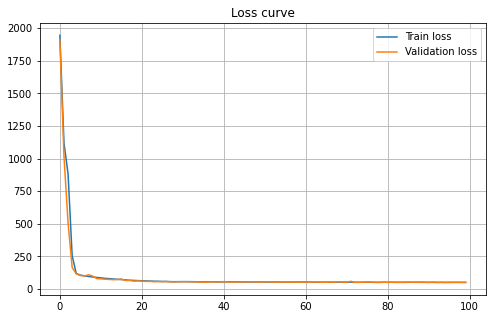

In [133]:
#plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.epoch,history.history['loss'], label='Train loss')
plt.plot(history.epoch,history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss curve')
plt.grid(True)
plt.show()

Predicitons

59/59 [==============================] - 1s 9ms/step


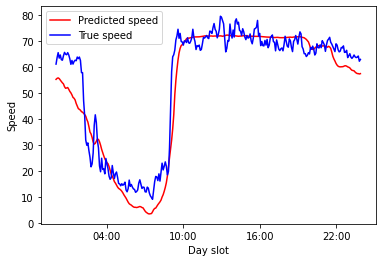

In [134]:
predictions = model.predict(X_test)
#predictions = scaler.inverse_transform(predictions)
#true_values = scaler.inverse_transform(Y_test)

day = np.arange(day_size).tolist()

sensor_n = 1

l1, = plt.plot(day, predictions[:day_size, sensor_n], color='red')
l2, = plt.plot(day, Y_test[:day_size, sensor_n], color='blue')

plt.legend((l1, l2), ['Predicted speed', 'True speed'])

plt.xlabel('Day slot')
plt.ylabel('Speed')
plt.xticks(np.arange(min(day) + 4*12, max(day) + 2, 6*12), labels=('04:00', '10:00', '16:00', '22:00'))

plt.show()

In [ ]:
#save model
#model.save('FNNtraffic.h5')
#download it
#files.download('/content/FNNtraffic.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Historical Average (HA)

In [135]:
M = 12
H = 3

In [136]:
def format_data(data, M, H):
  n_sensors = data.shape[1]
  total_len = len(data)
  window_len = total_len - M - H
  X = np.zeros([window_len, M,  n_sensors])
  Y = np.zeros([window_len, n_sensors])
  for i in range(window_len):
      start = i
      end = i + M
      X[i, :] = data[start: end].reshape(M,  n_sensors)
      Y[i] = data[end + H - 1]

  return np.array(X), np.array(Y)

In [137]:
#format data
X_set, Y_set = format_data(dataset, M, H)

#compute predictions
pred = np.mean(X_set, axis=1)

In [138]:
#print metrics
rmse = keras.metrics.RootMeanSquaredError()
rmse.update_state(pred, Y_set)

mae = keras.metrics.MeanAbsoluteError()
mae.update_state(pred, Y_set)

mape = keras.metrics.MeanAbsolutePercentageError()
mape.update_state(pred, Y_set)

print(f'Root Mean Squared Error = {float(rmse.result())}')
print(f'Mean Absolute Error = {float(mae.result())}')
print(f'Mean Absolute Percentage Error = {float(mape.result())}')

Root Mean Squared Error = 7.072145462036133
Mean Absolute Error = 3.6482460498809814
Mean Absolute Percentage Error = 8.32510757446289


Plot predictions

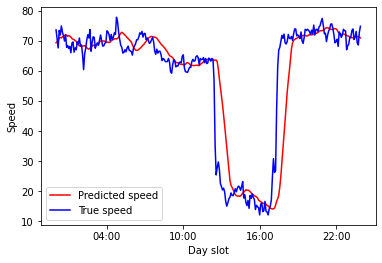

In [139]:
day = np.arange(day_size).tolist()

sensor_n = 1

l1, = plt.plot(day, pred[:day_size, sensor_n], color='red')
l2, = plt.plot(day, Y_set[:day_size, sensor_n], color='blue')

plt.legend((l1, l2), ['Predicted speed', 'True speed'])

plt.xlabel('Day slot')
plt.ylabel('Speed')
plt.xticks(np.arange(min(day) + 4*12, max(day) + 2, 6*12), labels=('04:00', '10:00', '16:00', '22:00'))

plt.show()